# Kriptonite

## Fast Preproc NB

In [1]:
import time

In [2]:
from __future__ import print_function

In [3]:
%matplotlib inline

In [4]:
%load_ext autoreload

In [5]:
%autoreload 2

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import tables as tb
import numpy as np

In [7]:
import tables
import Core.mplFunctions as mpl
import Core.wfmFunctions as wfm

In [8]:
from Database import loadDB

In [9]:
import ICython.Sierpe.BLR as blr
import ICython.Core.peakFunctions as pf
import Core.peakFunctions as cpf
from ICython.Core.system_of_units import SystemOfUnits 

In [10]:
from scipy import signal

In [11]:
%load_ext Cython

In [12]:
print(time.strftime("%d/%m/%Y"))
print(time.strftime("%H:%M:%S"))

09/12/2016
20:20:52


### Preproc Steps

1. Deconvolute RWF
2. Compute calibrated sum of PMTs (including MAU threshold)
3. Zero Suppression (ZS) in PMTs
4. S1 search (analysis specific)
5. S2 search (analysis specific)
6. ZS in SiPMs
7. Select S2 in ZS SiPMs 

For fast pre-proc, all the above steps must be computed on the fly (e.g, minimal access to disk) and
using pre-compiled (cython) functions in calculation-intensive parts (loops)

#### Test data: start from pmtrwf

In [14]:
path='/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/LSC/run2976/'
ffile = 'run_2976.gdc1next.000.next1el_2976.root.h5'
r2976 = tables.open_file(path+ffile,'r+')
pmtrwf = r2976.root.RD.pmtrwf

#### Access to data base and definition of units

In [25]:
DataPMT = loadDB.DataPMT(2976)
units = SystemOfUnits()
adc_to_pes = abs(DataPMT.adc_to_pes.values).astype(np.double)
coeff_c = abs(DataPMT.coeff_c.values).astype(np.double)
coeff_blr = abs(DataPMT.coeff_blr.values).astype(np.double)

#### Step 1:  Deconvolution (BLR)

In [16]:
event = 0
CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr)

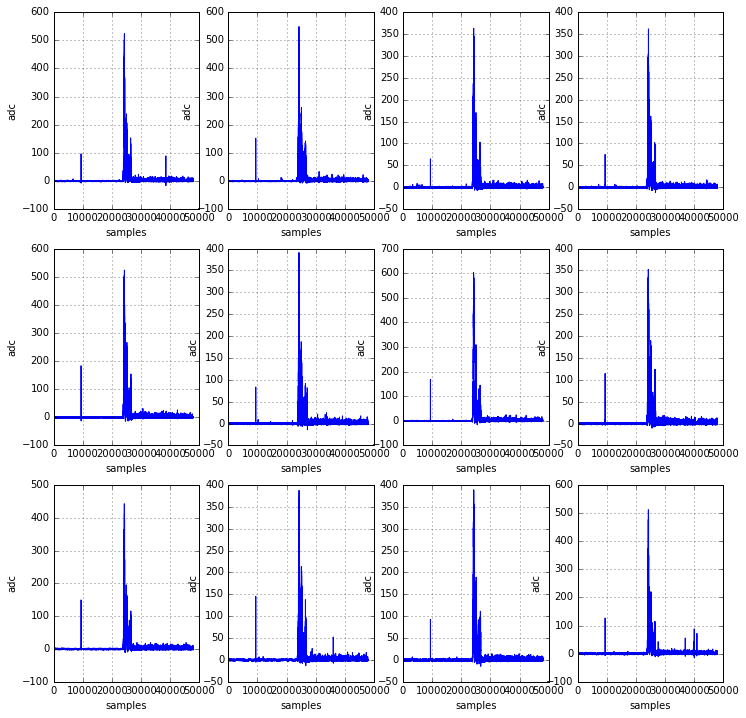

In [17]:
mpl.plot_waveforms(CWF)

#### Step 2: calibrated PMT sum

In [18]:
from time import time
t0 = time()
for event in range(pmtrwf.shape[0]):
    CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr)
t1 = time()        
dt = t1 - t0

print("run over {} events deconv_pmt cython in {} s".format(event,dt))
print("time/event {} s".format(dt/event))

run over 90 events deconv_pmt cython in 13.2901310921 s
time/event 0.147668123245 s


#### calibrated pmt sum

In [19]:
event = 0
CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr)
csum = pf.calibrated_pmt_sum(CWF, adc_to_pes, n_MAU=200, thr_MAU=5) 

In [20]:
wfm_length=48000 
tstep = 25
signal_t = np.arange(0., wfm_length * tstep, tstep)

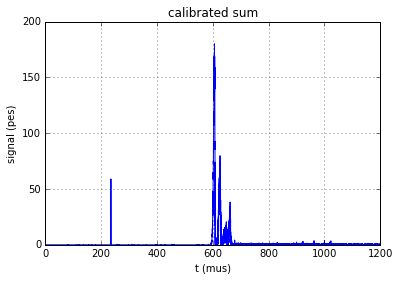

In [21]:
mpl.plot_signal(signal_t/units.mus, csum, title="calibrated sum",
                signal_start=0, signal_end=1200, 
                ymax = 200, 
                t_units='mus', units="pes")

In [22]:
t0 = time()
for event in range(pmtrwf.shape[0]):
    CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr)
    csum = pf.calibrated_pmt_sum(CWF, adc_to_pes, n_MAU=200, thr_MAU=5) 
t1 = time()        
dt = t1 - t0

print("run over {} events deconv_pmt cython in {} s".format(event,dt))
print("time/event {} s".format(dt/event))

run over 90 events deconv_pmt cython in 15.9518251419 s
time/event 0.177242501577 s


#### Step 3: ZS in PMTs

In [23]:
event = 0
CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr)
csum = pf.calibrated_pmt_sum(CWF, adc_to_pes, n_MAU=200, thr_MAU=5) 
wfzs_ene, wfzs_indx = pf.wfzs(csum, threshold=1*units.pes)
wfzs_t = pf.time_from_index(wfzs_indx)

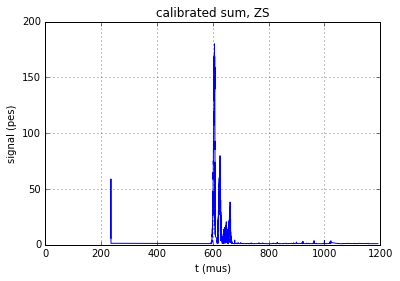

In [24]:
mpl.plot_signal(wfzs_t/units.mus, wfzs_ene, title="calibrated sum, ZS",
                signal_start=0, signal_end=1200, 
                ymax = 200, 
                t_units='mus', units="pes")

In [25]:
t0 = time()
for event in range(pmtrwf.shape[0]):
    CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr)
    csum = pf.calibrated_pmt_sum(CWF, adc_to_pes, n_MAU=200, thr_MAU=5)
    wfzs_ene, wfzs_indx = pf.wfzs(csum, threshold=1*units.pes)
    wfzs_t = pf.time_from_index(wfzs_indx)
t1 = time()        
dt = t1 - t0

print("run over {} events deconv_pmt cython in {} s".format(event,dt))
print("time/event {} s".format(dt/event))

run over 90 events deconv_pmt cython in 16.390486002 s
time/event 0.182116511133 s


##### python dataframe (reference)

In [26]:
event = 0
CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr)
csum = pf.calibrated_pmt_sum(CWF, adc_to_pes, n_MAU=200, thr_MAU=5) 
wfzs_ene, wfzs_indx = pf.wfzs(csum, threshold=1*units.pes)
wfzs_t = pf.time_from_index(wfzs_indx)
wfzs = cpf.wfdf(wfzs_t,wfzs_ene)

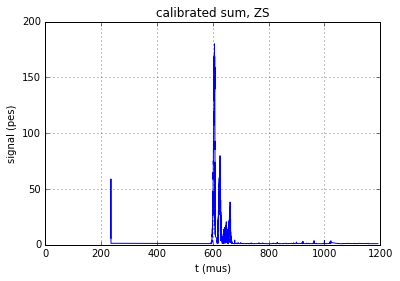

In [27]:
mpl.plot_signal(wfzs.time_ns/units.mus, wfzs.ene_pes, title="calibrated sum, ZS",
                signal_start=0, signal_end=1200, 
                ymax = 200, 
                t_units='mus', units="pes")

#### Step 4: Find S12 

In [28]:
event = 0
CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr)
csum = pf.calibrated_pmt_sum(CWF, adc_to_pes, n_MAU=200, thr_MAU=5) 
wfzs_ene, wfzs_indx = pf.wfzs(csum, threshold=1*units.pes)
wfzs_t = pf.time_from_index(wfzs_indx)
S1 = pf.find_S12(wfzs_ene, wfzs_indx, tmin=0,  tmax=590*units.mus, lmin=8, lmax=200, stride=4)
S2 = pf.find_S12(wfzs_ene, wfzs_indx, tmin=590*units.mus,  tmax=1100*units.mus, lmin=100, lmax=1000000, stride=40)

In [29]:
s1df = pd.DataFrame(S1[0],columns=['time_ns','ene_pes'])
s2df = pd.DataFrame(S2[0],columns=['time_ns','ene_pes'])

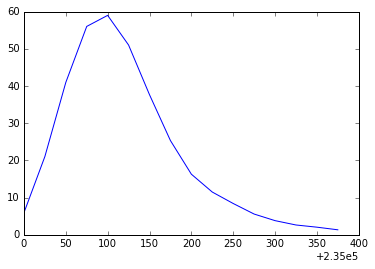

In [30]:
plt.plot(s1df.time_ns, s1df.ene_pes)

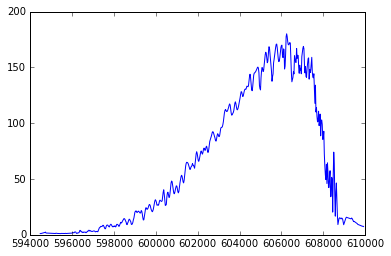

In [31]:
plt.plot(s2df.time_ns, s2df.ene_pes)

In [32]:
t0 = time()
for event in range(pmtrwf.shape[0]):
    CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr)
    csum = pf.calibrated_pmt_sum(CWF, adc_to_pes, n_MAU=200, thr_MAU=5)
    wfzs_ene, wfzs_indx = pf.wfzs(csum, threshold=1*units.pes)
    wfzs_t = pf.time_from_index(wfzs_indx)
    S1 = pf.find_S12(wfzs_ene, wfzs_indx, tmin=0,  tmax=590*units.mus, lmin=8, lmax=200, stride=4)
    S2 = pf.find_S12(wfzs_ene, wfzs_indx, tmin=590*units.mus,  tmax=1100*units.mus, lmin=100, lmax=1000000, stride=40)
t1 = time()        
dt = t1 - t0

print("run over {} events in {} s".format(event,dt))
print("time/event {} s".format(dt/event))

run over 90 events in 16.4733719826 s
time/event 0.183037466473 s


#### scan function (python)

In [35]:
event = 0
CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr)
csum = pf.calibrated_pmt_sum(CWF, adc_to_pes, n_MAU=200, thr_MAU=5) 
wfzs_ene, wfzs_indx = pf.wfzs(csum, threshold=1*units.pes)
wfzs_t = pf.time_from_index(wfzs_indx)
S1 = pf.find_S12(wfzs_ene, wfzs_indx, tmin=0,  tmax=590*units.mus, lmin=8, lmax=200, stride=4)
S2 = pf.find_S12(wfzs_ene, wfzs_indx, tmin=590*units.mus,  tmax=1100*units.mus, lmin=100, lmax=1000000, stride=40)

number of peaks = 1
S12 number = 0, samples = 16 sum in pes =348.554582675


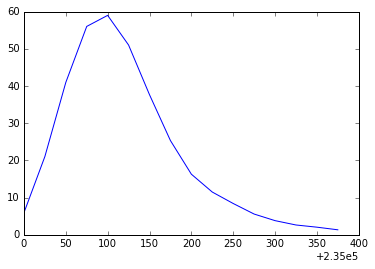

hit return


In [36]:
cpf.scan_S12(S1)

number of peaks = 3
S12 number = 0, samples = 551 sum in pes =37891.7684465


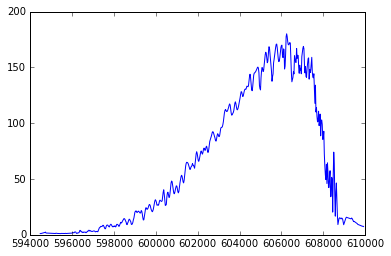

hit return
S12 number = 1, samples = 533 sum in pes =16931.5000759


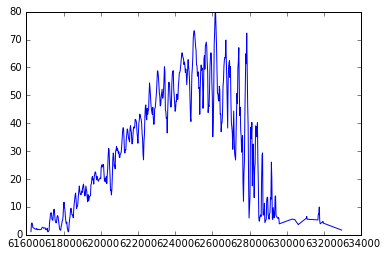

hit return
S12 number = 2, samples = 1173 sum in pes =11408.8409503


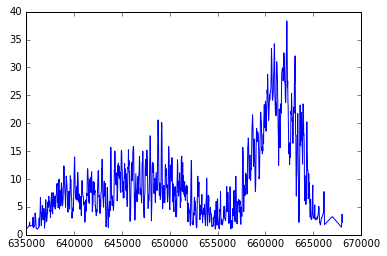

hit return


In [37]:
cpf.scan_S12(S2)

In [38]:
S1L = cpf.dict_to_df_S12(S1)

number of peaks = 1
S12 number = 0, samples = 16 sum in pes =348.554582675


number of peaks = 1
S12 number = 0, samples = 16 sum in pes =348.554582675


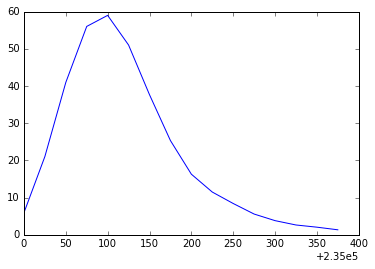

hit return


In [39]:
cpf.scan_S12L(S1L)

In [40]:
S2L = cpf.dict_to_df_S12(S2)

number of peaks = 3
S12 number = 0, samples = 551 sum in pes =37891.7684465
S12 number = 1, samples = 533 sum in pes =16931.5000759
S12 number = 2, samples = 1173 sum in pes =11408.8409503


number of peaks = 3
S12 number = 0, samples = 551 sum in pes =37891.7684465


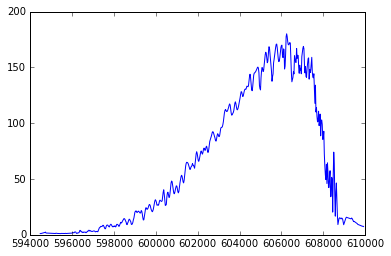

hit return
S12 number = 1, samples = 533 sum in pes =16931.5000759


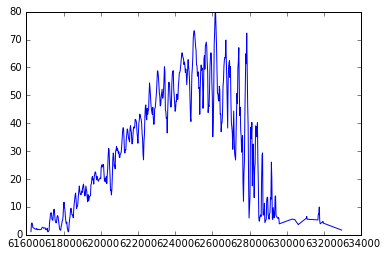

hit return
S12 number = 2, samples = 1173 sum in pes =11408.8409503


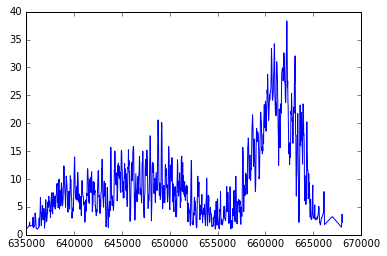

hit return


In [41]:
cpf.scan_S12L(S2L)

In [42]:
r2976.close()

In [96]:
class FastPP:
    """
    Fast Preprocessing

    """
    def __init__(self, run_number, n_baseline=28000, n_MAU=100,
                 thr_trigger=5, wfm_length=48000, tstep = 25):
        """
        Inits the machine
        """
        DataPMT = loadDB.DataPMT(run_number)
        DataSiPM = loadDB.DataSiPM(run_number)

        self.adc_to_pes = abs(DataPMT.adc_to_pes.values).astype(np.double)
        self.sipm_adc_to_pes = DataSiPM.adc_to_pes.values.astype(np.double)
        self.coeff_c = DataPMT.coeff_c.values.astype(np.double)
        self.coeff_blr = DataPMT.coeff_blr.values.astype(np.double)

        self.n_MAU = n_MAU
        self.n_baseline = n_baseline
        self.thr_trigger = thr_trigger
        self.signal_t = np.arange(0., wfm_length * tstep, tstep)

        self.setFiles = False
        self.setS1 = False
        self.setS2 = False

        self.plot_csum = False
        self.plot_s1 = False
        self.plot_s2 = False

        self.nprint = 1000000

        # Dictionary of S1 and S2
        
        self.dS1 = {}
        self.dS2 = {}

    def set_plot(self, plot_csum=False, plot_s1=False, plot_s2=False, 
                 plot_sipm=False, plot_sipmzs=False):
        
        self.plot_csum = plot_csum
        self.plot_s1 = plot_s1
        self.plot_s2 = plot_s2
        self.plot_sipm = plot_sipm
        self.plot_sipmzs = plot_sipmzs

    def set_print(self, nprint=10):
        self.nprint = nprint

    def set_files(self,path, input_files):
        """
        Sets the input files
        """
        self.path = path
        self.input_files = input_files
        self.setFiles = True

    def set_s1(self, tmin=0*units.mus, tmax=590*units.mus, stride=4, lmin=4, lmax=16):
        self.tmin_s1 = tmin
        self.tmax_s1 = tmax
        self.stride_s1 = stride
        self.lmin_s1 = lmin
        self.lmax_s1 = lmax
        self.setS1 = True

    def set_s2(self, tmin=590*units.mus, tmax=620*units.mus, stride=40, lmin=100, lmax=1000000):
        self.tmin_s2 = tmin
        self.tmax_s2 = tmax
        self.stride_s2 = stride
        self.lmin_s2 = lmin
        self.lmax_s2 = lmax
        self.setS2 = True

    def get_dS1(self):
        if len(self.dS1) == 0:
            print('S1 dictionary is empty')
            return 0
        else:
            return self.dS1

    def get_dS2(self):
        if len(self.dS2) == 0:
            print('S2 dictionary is empty')
            return 0
        else:
            return self.dS2

    def run(self, nmax, thr_s12=1.0*units.pes, thr_sipm=3.0*units.pes):
        """
        Run the machine

        """
        n_events_tot = 0

        if self.setFiles == False:
            raise IOError('must set files before running')
        if self.setS1 == False:
            raise IOError('must set S1 parameters before running')
        if self.setS2 == False:
            raise IOError('must set S2 parameters before running')
        if self.path =='':
            raise IOError('path is empty')
        if len(self.input_files) == 0:
            raise IOError('input file list is empty')

        for ffile in self.input_files:

            print("Opening", ffile, end="... ")
            filename = self.path + ffile
            #sys.stdout.flush()

            try:
                with tb.open_file(filename, "r+") as h5in:

                    pmtrwf = h5in.root.RD.pmtrwf
                    sipmrwf = h5f.root.RD.sipmrwf
                    NEVT = pmtrwf.shape[0]

                    for evt in range(NEVT):
                        # deconvolve
                        CWF = blr.deconv_pmt(pmtrwf[evt], self.coeff_c, self.coeff_blr,
                                         n_baseline=self.n_baseline,
                                         thr_trigger=self.thr_trigger)

                        # calibrated PMT sum
                        csum = pf.calibrated_pmt_sum(CWF, self.adc_to_pes,
                                                  n_MAU=self.n_MAU,
                                                  thr_MAU=self.thr_trigger)
                        if self.plot_csum:
                            plt.plot(csum)
                            plt.show()
                            raw_input('->')


                        # Supress samples below threshold (in pes)
                        wfzs_ene, wfzs_indx = pf.wfzs(csum, threshold=thr_s12)
                        
                        wfzs_ene, wfzs_indx = pf.wfzs(csum, threshold=1*units.pes)
    
                        # find S1 and S2
                        S1 = pf.find_S12(wfzs_ene, wfzs_indx,
                                         tmin=self.tmin_s1,
                                         tmax=self.tmax_s1,
                                         lmin=self.lmin_s1, lmax=self.lmax_s1,
                                         stride=self.stride_s1)

                        

                        S2 = pf.find_S12(wfzs_ene, wfzs_indx,
                                         tmin=self.tmin_s2,
                                         tmax=self.tmax_s2,
                                         lmin=self.lmin_s2, lmax=self.lmax_s2,
                                         stride=self.stride_s2)
                        
                        
                        self.dS1[n_events_tot] = S1
                        self.dS2[n_events_tot] = S2

                        if self.plot_s1:
                            scan_S12(S1)
                        if self.plot_s2:
                            scan_S12(S2)
                        
                        # sipms
                        
                        if self.plot_sipm:
                            mpl.plot_sipm(sipmrwf[evt], nmin=0, nmax=16, x=4, y=4)
                            
                        sipmzs = pf.signal_sipm(sipmrwf[evt], self.sipm_adc_to_pes, 
                                              thr=thr_sipm, n_MAU=self.n_MAU)
                        if self.plot_sipmzs:
                            mpl.plot_sipm(sipmzs, nmin=0, nmax=16, x=4, y=4)
                        
                        SiPML = pf.select_sipm(sipmzs)

                        n_events_tot +=1
                        if n_events_tot%self.nprint == 0:
                            print('event in file = {}, total = {}'.format(evt, n_events_tot))

                        if n_events_tot > nmax:
                            print('reached maximum number of events (={})'.format(nmax))
                            return nmax


            except:
                print('error')
                raise
        
        return n_events_tot


In [79]:
input_files =['run_2976.gdc1next.000.next1el_2976.root.h5']
path='/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/LSC/run2976/'

t0 = 1481279655.67 s
Opening run_2976.gdc1next.000.next1el_2976.root.h5... 

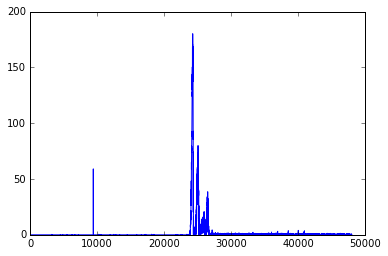

->
number of peaks = 1
S12 number = 0, samples = 16 sum in pes =349.241323023


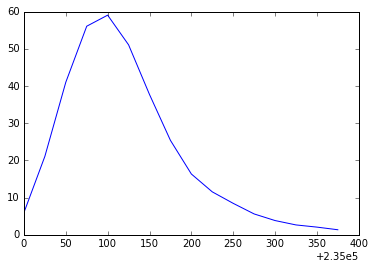

hit return
number of peaks = 3
S12 number = 0, samples = 551 sum in pes =37922.1382566


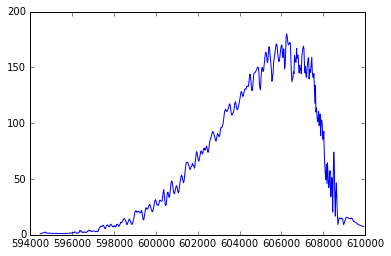

hit return
S12 number = 1, samples = 533 sum in pes =16984.0607176


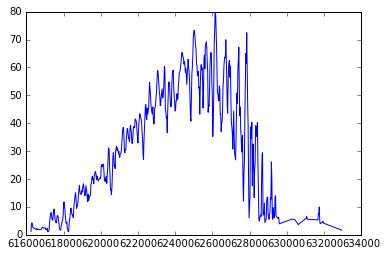

hit return
S12 number = 2, samples = 1174 sum in pes =11517.9098908


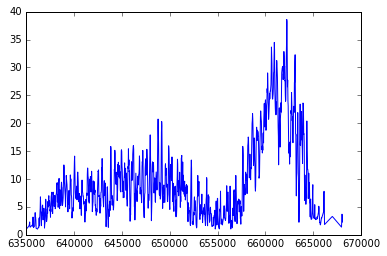

hit return
event in file = 0, total = 1


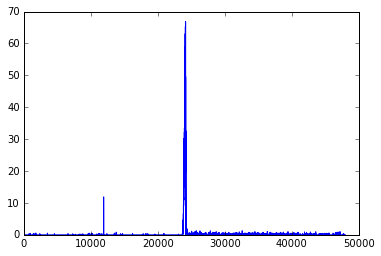

->
number of peaks = 1
S12 number = 0, samples = 8 sum in pes =51.4801736701


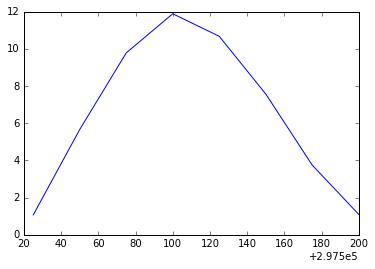

hit return
number of peaks = 1
S12 number = 0, samples = 475 sum in pes =12417.912519


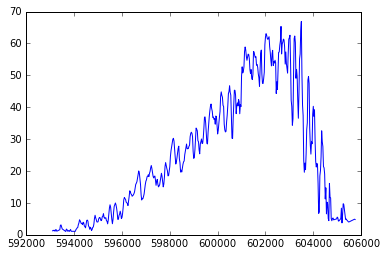

hit return
event in file = 1, total = 2


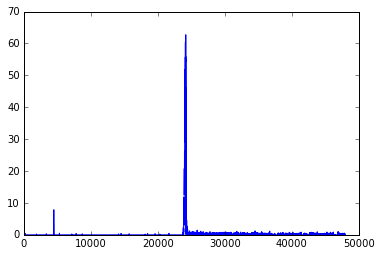

->
number of peaks = 1
S12 number = 0, samples = 13 sum in pes =44.9432823346


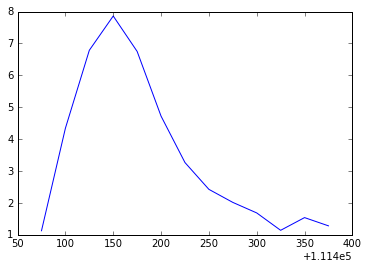

hit return
number of peaks = 1
S12 number = 0, samples = 431 sum in pes =11274.062152


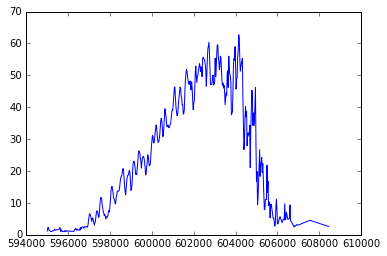

hit return
event in file = 2, total = 3


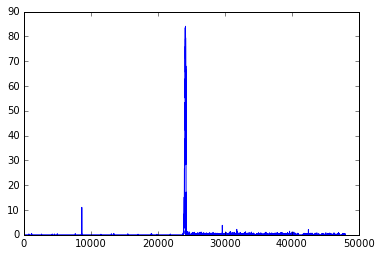

->
number of peaks = 1
S12 number = 0, samples = 10 sum in pes =57.5527606546


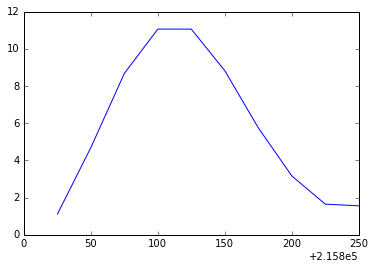

hit return
number of peaks = 1
S12 number = 0, samples = 407 sum in pes =13837.0839263


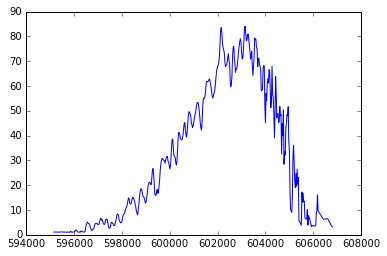

hit return
event in file = 3, total = 4
reached maximum number of events (=3)


In [82]:
fpp = FastPP(run_number=2976, n_baseline=40000, n_MAU=200,
             thr_trigger=5, wfm_length=48000)

fpp.set_files(path, input_files)  
fpp.set_s1(tmin=0*units.mus, tmax=590*units.mus, stride=4, lmin=8, lmax=20)
fpp.set_s2(tmin=590*units.mus, tmax=1100*units.mus, stride=40, lmin=100, lmax=100000)
fpp.set_plot(plot_csum=True, plot_s1=True, plot_s2=True)
fpp.set_print(nprint=1)
fpp.run(nmax=3, thr_s12=1.0*units.pes)

In [98]:
fpp = FastPP(run_number=2976, n_baseline=40000, n_MAU=200,
             thr_trigger=5, wfm_length=48000)

fpp.set_files(path, input_files)  
fpp.set_s1(tmin=0*units.mus, tmax=590*units.mus, stride=4, lmin=8, lmax=20)
fpp.set_s2(tmin=590*units.mus, tmax=1100*units.mus, stride=40, lmin=100, lmax=100000)

fpp.set_plot(plot_csum=False, plot_s1=False, plot_s2=False)
fpp.set_print(nprint=10)
t0 = time()
n_events_tot = fpp.run(nmax=100, thr_s12=1.0*units.pes)
t1 = time()  
dt = t1 - t0

print("run over {} events in {} s".format(n_events_tot,dt))
print("time/event {} s".format(dt/n_events_tot))

Opening run_2976.gdc1next.000.next1el_2976.root.h5... event in file = 9, total = 10
event in file = 19, total = 20
event in file = 29, total = 30
event in file = 39, total = 40
event in file = 49, total = 50
event in file = 59, total = 60
event in file = 69, total = 70
event in file = 79, total = 80
event in file = 89, total = 90
run over 91 events in 16.1956679821 s
time/event 0.17797437343 s


### SiPMs

In [27]:
from Core.RandomSampling import NoiseSampler as SiPMsNoiseSampler

In [28]:
path='/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/LSC/run3105/'
ffile = 'run_3105.gdc2next.000.next1el_3105.root.h5'
h5f = tables.open_file(path+ffile,'r+')
pmtrwf = h5f.root.RD.pmtrwf
sipmrwf = h5f.root.RD.sipmrwf
NEVT, NPMT, PMTWL = pmtrwf.shape
NEVT, NSIPM, SIPMWL = sipmrwf.shape

In [29]:
print(NEVT, NPMT, PMTWL,NSIPM, SIPMWL)

89 12 48000 1792 1200


In [30]:
DataSiPM = loadDB.DataSiPM(2976)
sipmdf = DataSiPM

In [31]:
sipms_noise_sampler_ = SiPMsNoiseSampler(SIPMWL)

In [32]:
SIPM_NOISE_CUT = 0.99999
sipms_thresholds_ = sipms_noise_sampler_.ComputeThresholds(
                                SIPM_NOISE_CUT, sipmdf['adc_to_pes'])

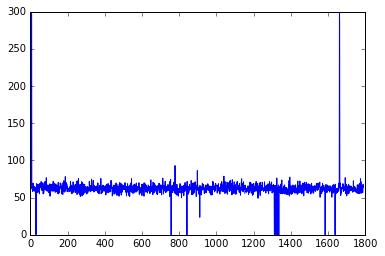

In [33]:
plt.plot(sipms_thresholds_)

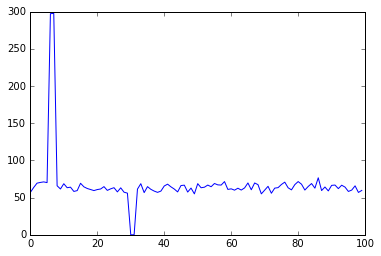

In [34]:
plt.plot(sipms_thresholds_[0:100])

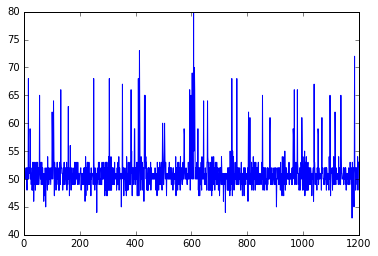

In [35]:
plt.plot(sipmrwf[0,0])

16 4 4


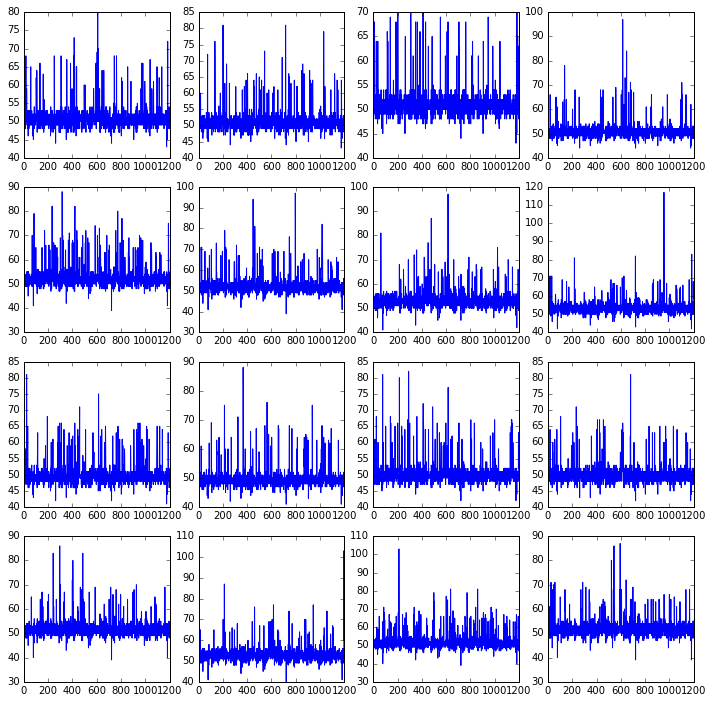

In [53]:
plot_sipm(sipmrwf[0], 16)

In [37]:
adc_to_pes = sipmdf.adc_to_pes.values

In [38]:
adc_to_pes.dtype

dtype('float64')

In [39]:
len(adc_to_pes)

1792

#### Draft version of cython function

In [57]:
%%cython
cimport numpy as np
import numpy as np
from scipy import signal

cpdef signal_sipm_draft(np.ndarray[np.int16_t, ndim=2] SIPM, double [:] adc_to_pes, double thr,
                  int n_MAU=100):
    """
    subtracts the baseline 
    Uses a MAU to set the signal threshold (thr, in PES)
    
    returns the ZS waveform

    """

    cdef int j, k
    cdef double [:, :] SiWF = SIPM.astype(np.double)
    cdef int NSiPM = SiWF.shape[0]
    cdef int NSiWF = SiWF.shape[1]
    cdef double [:] MAU = np.array(np.ones(n_MAU),
                                   dtype=np.double)*(1./float(n_MAU))

    
    cdef double [:, :] siwf = np.zeros((NSiPM,NSiWF), dtype=np.double)
    cdef double [:, :] MAU_sipm = np.zeros((NSiPM,NSiWF), dtype=np.double)
    cdef double [:] MAU_ = np.zeros(NSiWF, dtype=np.double)
    cdef double pmean 
    for j in range(NSiPM):
        if adc_to_pes[j] == 0:
            print('adc_to_pes[{}] = 0, setting sipm waveform to zero'.format(j))
            continue
        
        # compute the baseline
        pmean = 0
        for k in range(NSiWF):
            pmean += SiWF[j,k]
        pmean /= NSiWF
        
        for k in range(NSiWF):
            SiWF[j,k] = SiWF[j,k] - pmean
        
        # MAU for each of the SiPMs, following the waveform
        MAU_ = signal.lfilter(MAU,1,SiWF[j,:])
        
        # threshold using the MAU
        #for k in range(n_MAU):
        #    MAU_sipm[j, k] =  MAU_[n_MAU]
        #    siwf[j,k] = SiWF[j,k] - MAU_[n_MAU]
        for k in range(NSiWF):
            MAU_sipm[j, k] =  MAU_[k]
            #siwf[j,k] = SiWF[j,k] - MAU_[k]
            #siwf[j,k] = SiWF[j,k] - pmean
            if SiWF[j,k]  > MAU_[k] + thr * adc_to_pes[j]:
                siwf[j,k] = SiWF[j,k] 
                
            #siwf[j,k] = siwf[j,k] * 1./adc_to_pes[j]
            
    return np.asarray(siwf), np.asarray(MAU_sipm)




In [58]:
sipm, MAU = signal_sipm_draft(sipmrwf[0], adc_to_pes, thr=3*units.pes, n_MAU=100)

adc_to_pes[30] = 0, setting sipm waveform to zero
adc_to_pes[31] = 0, setting sipm waveform to zero
adc_to_pes[757] = 0, setting sipm waveform to zero
adc_to_pes[842] = 0, setting sipm waveform to zero
adc_to_pes[1312] = 0, setting sipm waveform to zero
adc_to_pes[1313] = 0, setting sipm waveform to zero
adc_to_pes[1321] = 0, setting sipm waveform to zero
adc_to_pes[1331] = 0, setting sipm waveform to zero
adc_to_pes[1336] = 0, setting sipm waveform to zero
adc_to_pes[1585] = 0, setting sipm waveform to zero
adc_to_pes[1638] = 0, setting sipm waveform to zero
adc_to_pes[1639] = 0, setting sipm waveform to zero


16 4 4


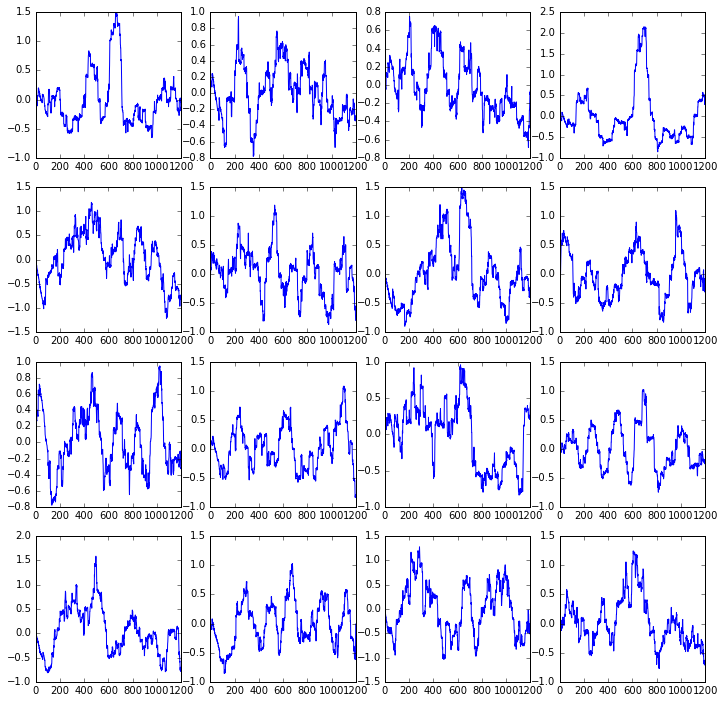

In [59]:
plot_sipm(MAU, 16)

16 4 4


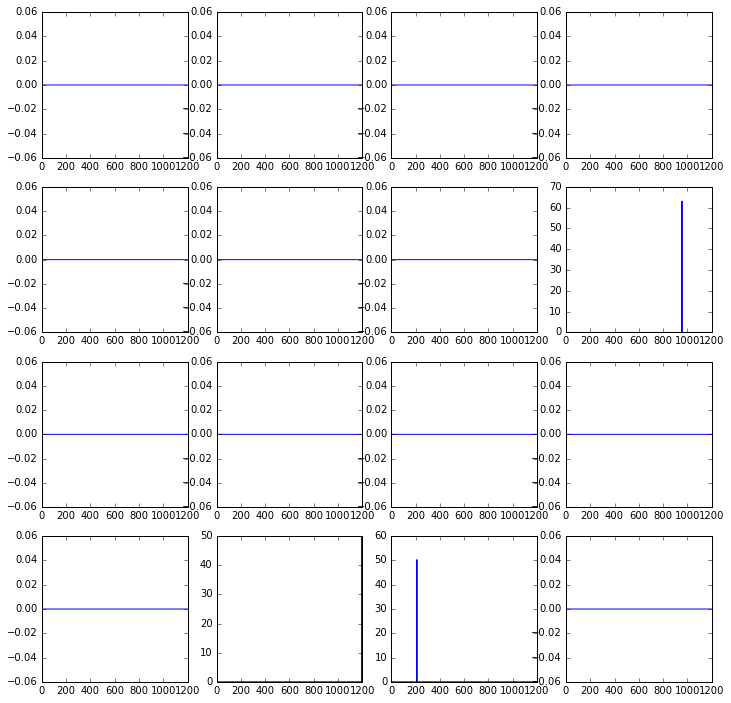

In [60]:
plot_sipm(sipm, 16)

#### cleaned up version

In [40]:
sipm = pf.signal_sipm(sipmrwf[0], adc_to_pes, thr=3*units.pes, n_MAU=100)

16 4 4


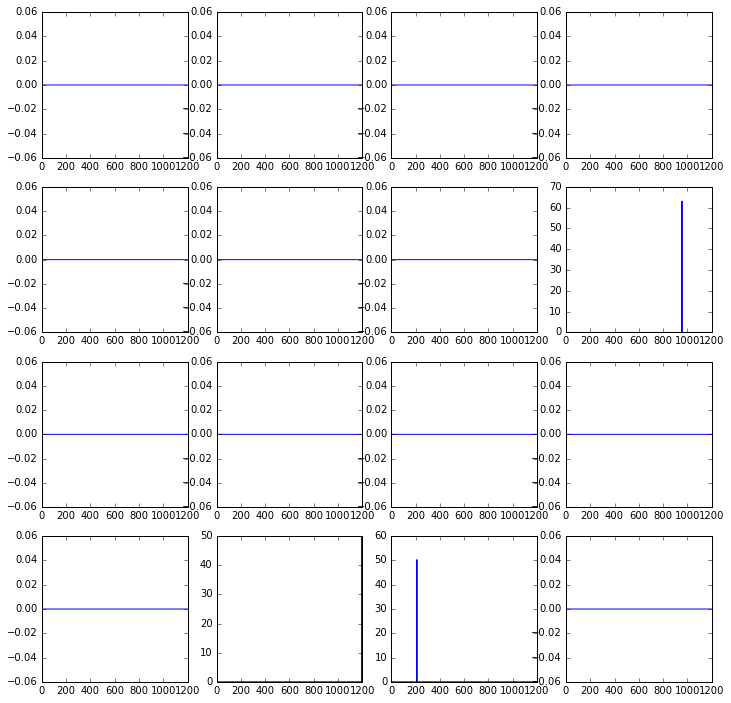

In [41]:
plot_sipm(sipm, 16)

In [65]:
sipm.shape

(1792, 1200)

In [43]:
from time import time
t0 = time()
sipm = pf.signal_sipm(sipmrwf[0], adc_to_pes, thr=3*units.pes, n_MAU=100)
t1 = time()        
dt = t1 - t0

print("run in {} s".format(dt))

run in 0.201419115067 s


In [65]:
%%cython
cimport numpy as np
import numpy as np
from scipy import signal

cpdef signal_sipm(np.ndarray[np.int16_t, ndim=2] SIPM,
                  double [:] adc_to_pes, double thr,
                  int n_MAU=100):
    """
    subtracts the baseline
    Uses a MAU to set the signal threshold (thr, in PES)
    returns ZS waveforms for all SiPMs

    """

    cdef int j, k
    cdef double [:, :] SiWF = SIPM.astype(np.double)
    cdef int NSiPM = SiWF.shape[0]
    cdef int NSiWF = SiWF.shape[1]
    cdef double [:] MAU = np.array(np.ones(n_MAU),
                                   dtype=np.double)*(1./float(n_MAU))


    cdef double [:, :] siwf = np.zeros((NSiPM,NSiWF), dtype=np.double)
    cdef double [:] MAU_ = np.zeros(NSiWF, dtype=np.double)
    cdef double pmean

    # loop over all SiPMs. Skip any SiPM with adc_to_pes constant = 0
    # since this means SiPM is dead
    for j in range(NSiPM):
        if adc_to_pes[j] == 0:
            #print('adc_to_pes[{}] = 0, setting sipm waveform to zero'.format(j))
            continue

        # compute and subtract the baseline
        pmean = 0
        for k in range(NSiWF):
            pmean += SiWF[j,k]
        pmean /= NSiWF

        for k in range(NSiWF):
            SiWF[j,k] = SiWF[j,k] - pmean

        # MAU for each of the SiPMs, following the ZS waveform
        MAU_ = signal.lfilter(MAU,1,SiWF[j,:])

        # threshold using the MAU
        for k in range(NSiWF):
            if SiWF[j,k]  > MAU_[k] + thr * adc_to_pes[j]:
                siwf[j,k] = SiWF[j,k]/adc_to_pes[j]

    return np.asarray(siwf)


In [66]:
from time import time
t0 = time()
sipm = signal_sipm(sipmrwf[0], adc_to_pes, thr=3*units.pes, n_MAU=100)
t1 = time()        
dt = t1 - t0

print("run in {} s".format(dt))

run in 0.208207130432 s


In [57]:
%%cython
cimport numpy as np
import numpy as np

def select_sipm(double [:, :] sipmzs):
    """
    Selects the SiPMs with signal 
    """
    cdef int NSIPM = sipmzs.shape[0]
    cdef int NWFM = sipmzs.shape[1]
    cdef dict SIPM = {}
    cdef int i, j, k
    cdef double psum
    
    j=0
    for i in range(NSIPM):
        psum = 0
        for k in range(NWFM):
            psum += sipmzs[i,k]
        if psum > 0:
            SIPM[j] = np.asarray(sipmzs[i]) 
            j+=1
    return SIPM
    

In [67]:
t0 = time()
SiPML = select_sipm(sipm)
t1 = time()        
dt = t1 - t0

print("run in {} s".format(dt))

run in 0.00660300254822 s


In [68]:
len(SiPML)

366

In [60]:
SiPML[0].dtype

dtype('float64')

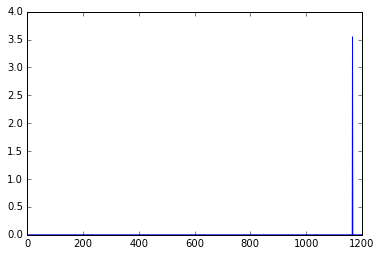

In [69]:
plt.plot(SiPML[3])

In [ ]:
rebin_waveform(double [:] t, double[:] e, int stride = 40)

### Driver class

### Test driver

### Run 2976

In [22]:
ls /Users/jjgomezcadenas/Documents/Development/NEXT/icdata/LSC/run2976

run_2976.gdc1next.000.next1el_2976.root.h5
run_2976.gdc1next.001.next1el_2976.root.h5
run_2976.gdc1next.002.next1el_2976.root.h5
run_2976.gdc1next.003.next1el_2976.root.h5
run_2976.gdc1next.004.next1el_2976.root.h5
run_2976.gdc1next.005.next1el_2976.root.h5


In [138]:
input_files =['run_2976.gdc1next.000.next1el_2976.root.h5',
              'run_2976.gdc1next.001.next1el_2976.root.h5',
              'run_2976.gdc1next.002.next1el_2976.root.h5',
              'run_2976.gdc1next.003.next1el_2976.root.h5',
              'run_2976.gdc1next.004.next1el_2976.root.h5',
              'run_2976.gdc1next.005.next1el_2976.root.h5']

In [76]:
input_files = ['run_2976.gdc2next.000.next1el_2976.root.h5',
'run_2976.gdc2next.001.next1el_2976.root.h5',
'run_2976.gdc2next.002.next1el_2976.root.h5',
'run_2976.gdc2next.003.next1el_2976.root.h5',
'run_2976.gdc2next.004.next1el_2976.root.h5',
'run_2976.gdc2next.005.next1el_2976.root.h5',
'run_2976.gdc2next.006.next1el_2976.root.h5',
'run_2976.gdc2next.007.next1el_2976.root.h5',
'run_2976.gdc2next.008.next1el_2976.root.h5',
'run_2976.gdc2next.009.next1el_2976.root.h5',
'run_2976.gdc2next.010.next1el_2976.root.h5',
'run_2976.gdc2next.011.next1el_2976.root.h5',
'run_2976.gdc2next.012.next1el_2976.root.h5',
'run_2976.gdc2next.013.next1el_2976.root.h5',
'run_2976.gdc2next.014.next1el_2976.root.h5',
'run_2976.gdc2next.015.next1el_2976.root.h5',
'run_2976.gdc2next.016.next1el_2976.root.h5',
'run_2976.gdc2next.017.next1el_2976.root.h5',
'run_2976.gdc2next.018.next1el_2976.root.h5',
'run_2976.gdc2next.019.next1el_2976.root.h5',
'run_2976.gdc2next.020.next1el_2976.root.h5',
'run_2976.gdc2next.021.next1el_2976.root.h5',
'run_2976.gdc2next.022.next1el_2976.root.h5',
'run_2976.gdc2next.023.next1el_2976.root.h5',
'run_2976.gdc2next.024.next1el_2976.root.h5',
'run_2976.gdc2next.025.next1el_2976.root.h5',
'run_2976.gdc2next.026.next1el_2976.root.h5',
'run_2976.gdc2next.027.next1el_2976.root.h5',
'run_2976.gdc2next.028.next1el_2976.root.h5',
'run_2976.gdc2next.029.next1el_2976.root.h5',
'run_2976.gdc2next.030.next1el_2976.root.h5',
'run_2976.gdc2next.031.next1el_2976.root.h5',
'run_2976.gdc2next.032.next1el_2976.root.h5',
'run_2976.gdc2next.033.next1el_2976.root.h5',
'run_2976.gdc2next.034.next1el_2976.root.h5',
'run_2976.gdc2next.035.next1el_2976.root.h5',
'run_2976.gdc2next.036.next1el_2976.root.h5',
'run_2976.gdc2next.037.next1el_2976.root.h5',
'run_2976.gdc2next.038.next1el_2976.root.h5',
'run_2976.gdc2next.039.next1el_2976.root.h5',
'run_2976.gdc2next.040.next1el_2976.root.h5',
'run_2976.gdc2next.041.next1el_2976.root.h5',
'run_2976.gdc2next.042.next1el_2976.root.h5',
'run_2976.gdc2next.043.next1el_2976.root.h5',
'run_2976.gdc2next.044.next1el_2976.root.h5',
'run_2976.gdc2next.045.next1el_2976.root.h5',
'run_2976.gdc2next.046.next1el_2976.root.h5',
'run_2976.gdc2next.047.next1el_2976.root.h5',
'run_2976.gdc2next.048.next1el_2976.root.h5',
'run_2976.gdc2next.049.next1el_2976.root.h5',
'run_2976.gdc2next.050.next1el_2976.root.h5',
'run_2976.gdc2next.051.next1el_2976.root.h5',
'run_2976.gdc2next.052.next1el_2976.root.h5',
'run_2976.gdc2next.053.next1el_2976.root.h5',
'run_2976.gdc2next.054.next1el_2976.root.h5',
'run_2976.gdc2next.055.next1el_2976.root.h5',
'run_2976.gdc2next.056.next1el_2976.root.h5',
'run_2976.gdc2next.057.next1el_2976.root.h5',
'run_2976.gdc2next.058.next1el_2976.root.h5',
'run_2976.gdc2next.059.next1el_2976.root.h5',
'run_2976.gdc2next.060.next1el_2976.root.h5',
'run_2976.gdc2next.061.next1el_2976.root.h5',
'run_2976.gdc2next.062.next1el_2976.root.h5',
'run_2976.gdc2next.063.next1el_2976.root.h5',
'run_2976.gdc2next.064.next1el_2976.root.h5',
'run_2976.gdc2next.065.next1el_2976.root.h5',
'run_2976.gdc2next.066.next1el_2976.root.h5']

In [54]:
input_files =['run_2976.gdc1next.000.next1el_2976.root.h5']

t0 = 1481230632.0 s
Opening run_2976.gdc1next.000.next1el_2976.root.h5... 

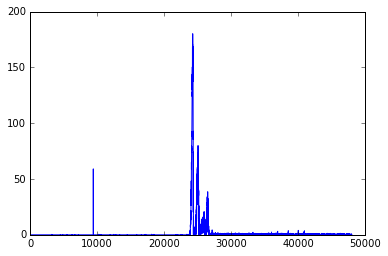

->
number of peaks = 1
S12 number = 0, samples = 16 sum in pes =349.241323023


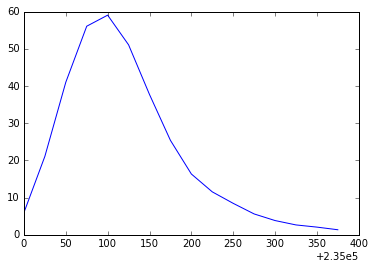

hit return
number of peaks = 3
S12 number = 0, samples = 551 sum in pes =37922.1382566


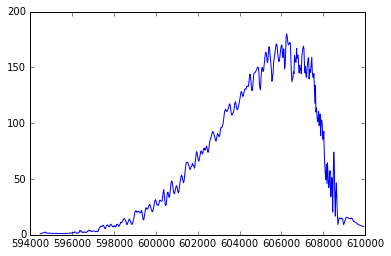

hit return
S12 number = 1, samples = 533 sum in pes =16984.0607176


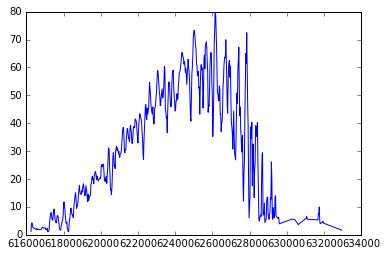

hit return
S12 number = 2, samples = 1174 sum in pes =11517.9098908


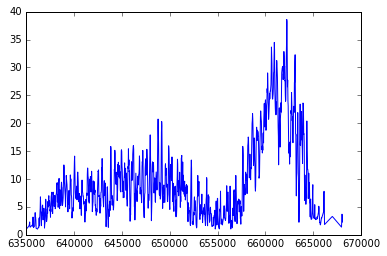

hit return
event in file = 0, total = 1


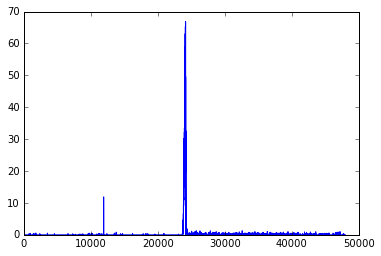

->
number of peaks = 1
S12 number = 0, samples = 8 sum in pes =51.4801736701


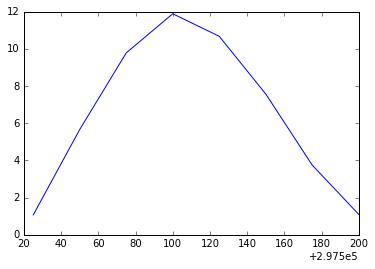

hit return
number of peaks = 1
S12 number = 0, samples = 475 sum in pes =12417.912519


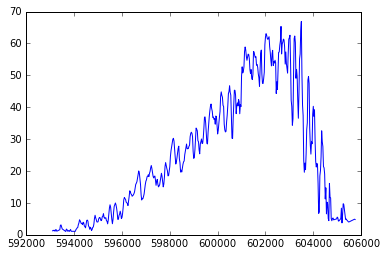

hit return
event in file = 1, total = 2


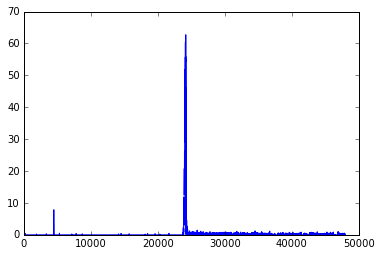

->
number of peaks = 1
S12 number = 0, samples = 13 sum in pes =44.9432823346


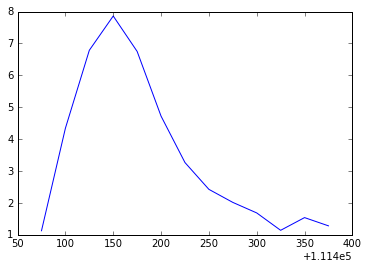

hit return
number of peaks = 1
S12 number = 0, samples = 431 sum in pes =11274.062152


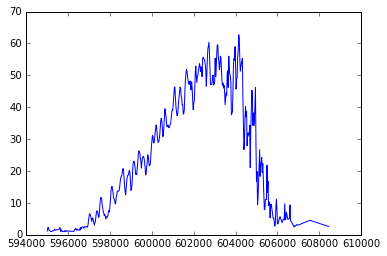

hit return
event in file = 2, total = 3


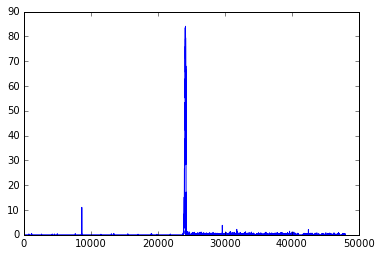

->
number of peaks = 1
S12 number = 0, samples = 10 sum in pes =57.5527606546


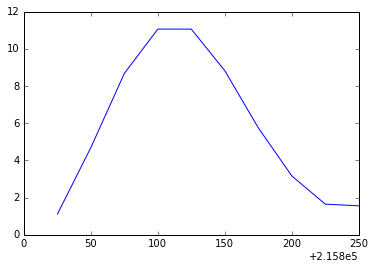

hit return
number of peaks = 1
S12 number = 0, samples = 407 sum in pes =13837.0839263


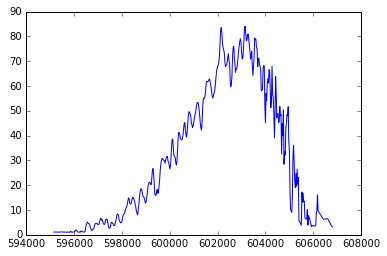

hit return
event in file = 3, total = 4
reached maximum number of events (=3)
Opening run_2976.gdc1next.001.next1el_2976.root.h5... event in file = 0, total = 5
reached maximum number of events (=3)
Opening run_2976.gdc1next.002.next1el_2976.root.h5... event in file = 0, total = 6
reached maximum number of events (=3)
Opening run_2976.gdc1next.003.next1el_2976.root.h5... event in file = 0, total = 7
reached maximum number of events (=3)
Opening run_2976.gdc1next.004.next1el_2976.root.h5... event in file = 0, total = 8
reached maximum number of events (=3)
Opening run_2976.gdc1next.005.next1el_2976.root.h5... event in file = 0, total = 9
reached maximum number of events (=3)
t1 = 1481230656.72 s
S12Finder has run over 10 events in 24.7269001007 seconds


In [75]:
s12f = cpf.S12Finder(run_number=2976, n_baseline=40000, n_MAU=200,
                 thr_trigger=5, wfm_length=48000)
s12f.set_files(path, input_files)  
s12f.set_s1(tmin=0*units.mus, tmax=590*units.mus, stride=4, lmin=8, lmax=20)
s12f.set_s2(tmin=590*units.mus, tmax=900*units.mus, stride=40, lmin=100, lmax=250000)
s12f.set_plot(plot_csum=True, plot_s1=True, plot_s2=True)
s12f.set_print(nprint=1)
s12f.find_s12(nmax=3, thr_s12=1.0*units.pes)

In [77]:
s12f = cpf.S12Finder(run_number=2976, n_baseline=40000, n_MAU=200,
                     thr_trigger=5, wfm_length=48000)
s12f.set_files(path, input_files)  
s12f.set_s1(tmin=0*units.mus, tmax=590*units.mus, stride=4, lmin=8, lmax=20)
s12f.set_s2(tmin=590*units.mus, tmax=900*units.mus, stride=40, lmin=100, lmax=250000)
s12f.set_plot(plot_csum=False, plot_s1=False, plot_s2=False)
s12f.set_print(nprint=10)
s12f.find_s12(nmax=2000000, thr_s12=1.0*units.pes)

t0 = 1481230713.06 s
Opening run_2976.gdc2next.000.next1el_2976.root.h5... event in file = 9, total = 10
event in file = 19, total = 20
event in file = 29, total = 30
event in file = 39, total = 40
event in file = 49, total = 50
event in file = 59, total = 60
event in file = 69, total = 70
event in file = 79, total = 80
event in file = 89, total = 90
Opening run_2976.gdc2next.001.next1el_2976.root.h5... event in file = 8, total = 100
event in file = 18, total = 110
event in file = 28, total = 120
event in file = 38, total = 130
event in file = 48, total = 140
event in file = 58, total = 150
event in file = 68, total = 160
event in file = 78, total = 170
event in file = 88, total = 180
Opening run_2976.gdc2next.002.next1el_2976.root.h5... event in file = 7, total = 190
event in file = 17, total = 200
event in file = 27, total = 210
event in file = 37, total = 220
event in file = 47, total = 230
event in file = 57, total = 240
event in file = 67, total = 250
event in file = 77, total = 2

In [78]:
1110./6036.

0.18389662027833

In [79]:
dS1 = s12f.get_dS1()
dS2 = s12f.get_dS2()

In [80]:
len(dS1.keys())

6035

In [81]:
len(dS2.keys())

6035

In [82]:
dS1[0][0].describe()

,time_ns,ene_pes
count,17.000000,17.000000
mean,274479.411765,10.098702
std,132.945975,10.292614
min,274275.000000,1.080829
25%,274375.000000,1.526385
50%,274475.000000,5.883077
75%,274575.000000,16.977754
max,274700.000000,29.352505


In [83]:
def rebin_waveform(swf, stride = 40):
    """
    rebins the a waveform according to stride
    The input waveform is a vector such that the index expresses time bin and the
    contents expresses energy (e.g, in pes)
    The function returns a DataFrame. The time bins and energy are rebinned according to stride
    """

    t = swf['time_ns'].values
    e = swf['ene_pes'].values
    n = len(swf)/int(stride)
    r = len(swf)%int(stride)

    lenb = n
    if r > 0:
        lenb = n+1

    T = np.zeros(lenb, dtype=np.double)
    E = np.zeros(lenb, dtype=np.double)
    
    j=0
    for i in range(n):
        E[i] = np.sum(e[j:j+stride])
        T[i] = np.mean(t[j:j+stride])
        j+= stride

    if r > 0:
        E[n] = np.sum(e[j:])
        T[n] = np.mean(t[j:])


    rbw={}
    rbw['ene_pes'] = E
    rbw['time_ns'] = T
    return pd.DataFrame(rbw)

In [92]:
evt = dS2.keys()
t0 = time()
nwf = 0
for i in evt:
    s2l = dS2[i]
    nwf +=len(s2l)
    for s2 in s2l:
        s2rb = rebin_waveform(s2, stride = 40)
t1 = time()        
dt = t1 - t0

print("rebinned {} wfm in {} s".format(nwf, dt))

rebinned 7169 wfm in 3.01973199844 s


In [93]:
3./7169.

0.00041846840563537454

In [87]:
dS2[0][0].describe()

,time_ns,ene_pes
count,387.000000,387.000000
mean,601514.664083,60.792493
std,2840.472967,48.590261
min,595675.000000,1.000572
25%,599112.500000,13.207976
50%,601525.000000,52.001699
75%,603937.500000,108.787565
max,606875.000000,145.221633


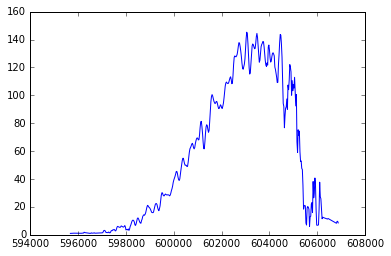

In [88]:
plt.plot(dS2[0][0].time_ns.values,dS2[0][0].ene_pes)

In [89]:
s2rb = rebin_waveform(dS2[0][0], stride = 40)

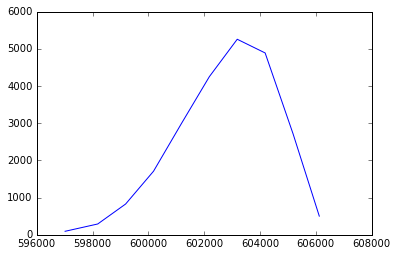

In [90]:
plt.plot(s2rb.time_ns.values,s2rb.ene_pes)

In [76]:
%%cython
cimport numpy as np
import numpy as np

cpdef rebin_waveform(double [:] t, double[:] e, int stride = 40):
    """
    rebins the a waveform according to stride
    The input waveform is a vector such that the index expresses time bin and the
    contents expresses energy (e.g, in pes)
    The function returns a DataFrame. The time bins and energy are rebinned according to stride
    """

    assert(len(t) == len(e))

    cdef int n = len(t)/stride
    cdef int r = len(t)%stride

    lenb = n
    if r > 0:
        lenb = n+1

    cdef double [:] T = np.zeros(lenb, dtype=np.double)
    cdef double [:] E = np.zeros(lenb, dtype=np.double)

    cdef int j=0
    cdef int i, k
    cdef double esum, tmean
    for i in range(n):
        esum = 0
        tmean = 0
        for k in range(j, j + stride):
            esum += e[k]
            tmean += t[k]

        tmean /= float(stride)
        E[i] = esum
        T[i] = tmean
        j+= stride

    if r > 0:
        esum = 0
        tmean = 0
        for k in range(j, len(t)):
            esum += e[k]
            tmean += t[k]
        tmean /= float(len(t) - j)
        E[n] = esum
        T[n] = tmean


    return np.asarray(T), np.asarray(E)

cpdef rebin_S2(dict S2, stride = 40 ):
    """
    rebins a S2
    """
    cdef int i,j
    cdef list ndim = []
    cdef dict S2R = {}
    for i in S2.keys():
        ndim.append(len(S2[i]))
    
    for i in S2.keys():
        T = np.zeros(ndim[i], dtype=np.double)
        E = np.zeros(ndim[i], dtype=np.double)
        
        for j in range(len(S2[i])):
            T[j] = S2[i][j][0]
            E[j] = S2[i][j][1]
            TR, ER = rebin_waveform(T, T, stride = stride)
            S2R[i] = [TR,ER]
    


Error compiling Cython file:
------------------------------------------------------------
...
        
        for j in range(len(S2[i])):
            T[j] = S2[i][j][0]
            E[j] = S2[i][j][1]
            TR, ER = rebin_waveform(T, T, stride = stride)
            S2R[i] = [TR,ER]
              ^
------------------------------------------------------------

/Users/jjgomezcadenas/.ipython/cython/_cython_magic_2dabe7ad09ab3f150d4ac8251473f833.pyx:70:15: local variable 'S2R' referenced before assignment


In [142]:
evt = dS2.keys()
t0 = time()
nwf = 0
for i in evt:
    s2l = dS2[i]
    nwf +=len(s2l)
    for s2 in s2l:
        T,E = crebin_waveform(s2.time_ns.values, s2.ene_pes.values, stride = 40)
        s2rb = [T,E]
        #s2rb = cpf.wfdf(T,E)
t1 = time()        
dt = t1 - t0

print("rebinned {} wfm in {} s".format(nwf, dt))

rebinned 7169 wfm in 0.257681846619 s


In [136]:
387./40.

9.675

In [137]:
9*40

360

In [138]:
s2 = dS2[0][0]
T,E = crebin_waveform(s2.time_ns.values, s2.ene_pes.values, stride = 40)
s2rb = cpf.wfdf(T,E)

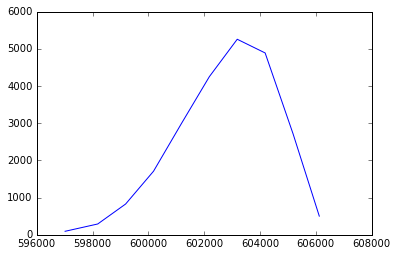

In [139]:
plt.plot(T,E)

In [ ]:
class S12Finder:
    """
    Driver class to find S12

    """
    def __init__(self, run_number, n_baseline=28000, n_MAU=200,
                 thr_trigger=5, wfm_length=48000, tstep = 25):
        """
        Inits the machine
        """
        DataPMT = loadDB.DataPMT(run_number)
        self.adc_to_pes = abs(DataPMT.adc_to_pes.values).astype(np.double)
        self.coeff_c = DataPMT.coeff_c.values.astype(np.double)
        self.coeff_blr = DataPMT.coeff_blr.values.astype(np.double)

        self.n_MAU = n_MAU
        self.n_baseline = n_baseline
        self.thr_trigger = thr_trigger
        self.signal_t = np.arange(0., wfm_length * tstep, tstep)

        self.setFiles = False
        self.setS1 = False
        self.setS2 = False

        self.plot_csum = False
        self.plot_s1 = False
        self.plot_s2 = False

        self.nprint = 1000000

        # Dictionary of S1 and S2
        # each entry contains a list of S1 and S2 df

        self.dS1 = {}
        self.dS2 = {}

    def set_plot(self, plot_csum=False, plot_s1=False, plot_s2=False):
        self.plot_csum = plot_csum
        self.plot_s1 = plot_s1
        self.plot_s2 = plot_s2

    def set_print(self, nprint=10):
        self.nprint = nprint

    def set_files(self,path, input_files):
        """
        Sets the input files
        """
        self.path = path
        self.input_files = input_files
        self.setFiles = True

    def set_s1(self, tmin=0*units.mus, tmax=590*units.mus, stride=4, lmin=4, lmax=16):
        self.tmin_s1 = tmin
        self.tmax_s1 = tmax
        self.stride_s1 = stride
        self.lmin_s1 = lmin
        self.lmax_s1 = lmax
        self.setS1 = True

    def set_s2(self, tmin=590*units.mus, tmax=620*units.mus, stride=40, lmin=100, lmax=1000000):
        self.tmin_s2 = tmin
        self.tmax_s2 = tmax
        self.stride_s2 = stride
        self.lmin_s2 = lmin
        self.lmax_s2 = lmax
        self.setS2 = True

    def get_dS1(self):
        if len(self.dS1) == 0:
            print('S1 dictionary is empty')
            return 0
        else:
            return self.dS1

    def get_dS2(self):
        if len(self.dS2) == 0:
            print('S2 dictionary is empty')
            return 0
        else:
            return self.dS2

    def find_s12(self, nmax, thr_s12=1.0*units.pes):
        """
        Run the machine

        """
        n_events_tot = 0

        if self.setFiles == False:
            raise IOError('must set files before running')
        if self.setS1 == False:
            raise IOError('must set S1 parameters before running')
        if self.setS2 == False:
            raise IOError('must set S2 parameters before running')
        if self.path =='':
            raise IOError('path is empty')
        if len(self.input_files) == 0:
            raise IOError('input file list is empty')


        t0 = time()
        print('t0 = {} s'.format(t0))
        for ffile in self.input_files:

            print("Opening", ffile, end="... ")
            filename = self.path + ffile
            #sys.stdout.flush()

            try:
                with tb.open_file(filename, "r+") as h5in:

                    pmtrwf = h5in.root.RD.pmtrwf
                    NEVT = pmtrwf.shape[0]

                    for evt in range(NEVT):
                        # deconvolve
                        CWF = blr.deconv_pmt(pmtrwf[evt], self.coeff_c, self.coeff_blr,
                                         n_baseline=self.n_baseline,
                                         thr_trigger=self.thr_trigger)

                        # calibrated PMT sum
                        csum = pf.calibrated_pmt_sum(CWF, self.adc_to_pes,
                                                  n_MAU=self.n_MAU,
                                                  thr_MAU=self.thr_trigger)
                        if self.plot_csum:
                            plt.plot(csum)
                            plt.show()
                            raw_input('->')


                        # Supress samples below threshold (in pes)
                        wfzs_ene, wfzs_indx = pf.wfzs(csum, threshold=thr_s12)

                        # find S1 and S2
                        S1 = pf.find_S12(wfzs_ene, wfzs_indx,
                                         tmin=self.tmin_s1,
                                         tmax=self.tmax_s1,
                                         stride=self.stride_s1)

                        s1df = s12_df(S1, lmin=self.lmin_s1, lmax=self.lmax_s1)

                        S2 = pf.find_S12(wfzs_ene, wfzs_indx,
                                         tmin=self.tmin_s2,
                                         tmax=self.tmax_s2,
                                         stride=self.stride_s2)
                        s2df = s12_df(S2, lmin=self.lmin_s2, lmax=self.lmax_s2)

                        self.dS1[n_events_tot] = s1df
                        self.dS2[n_events_tot] = s2df

                        if self.plot_s1:
                            scan_S12(s1df)
                        if self.plot_s2:
                            scan_S12(s2df)

                        n_events_tot +=1
                        if n_events_tot%self.nprint == 0:
                            print('event in file = {}, total = {}'.format(evt, n_events_tot))

                        if n_events_tot > nmax:
                            print('reached maximum number of events (={})'.format(nmax))
                            self.plot_csum = False
                            self.plot_s1 = False
                            self.plot_s2 = False
                            break


            except:
                print('error')
                raise


        t1 = time()
        print('t1 = {} s'.format(t1))
        dt = t1 - t0

        print("S12Finder has run over {} events in {} seconds".format(n_events_tot+1, dt))


In [112]:
def get_s12df(dS12):
    """
    Defines lists of S12 objects
    """
    
    evt = []  # event number
    n_s12 = []   # s12 number
    peak = [] # peak in pes
    width = [] # width in mus
    tpeak = [] # s12 time
    pes = []  # energy in pes
    peak_to_pes = []
    
    for key in dS12.keys():        
        S12L = dS12[key]
        n=0
        for s12df in S12L:
            n+=1
            evt.append(key)
            n_s12.append(n)
            peak.append(s12df.ene_pes.max())
            tpeak.append(s12df.time_ns.max())
            width.append(s12df.ene_pes.count())
            pes.append(np.sum(s12df.ene_pes.values))
            peak_to_pes.append(s12df.ene_pes.max()/np.sum(s12df.ene_pes.values))
            
    swf = {}
    swf['evt'] = evt
    swf['n_s12'] = n_s12 
    swf['peak'] = peak
    swf['width'] = width
    swf['tpeak'] = tpeak
    swf['pes'] = pes
    swf['peak_to_pes'] = peak_to_pes
    
    return pd.DataFrame(swf)
                
                
        

In [172]:
def s1s2_df(dS1, dS2):
    """
    Creates a PD dataframe with the information of S1 and S2
    """
    
    n_s1 = []   # s12 number
    peak_s1 = [] # peak in pes
    width_s1 = [] # width in mus
    tpeak_s1 = [] # s12 time
    pes_s1 = []  # energy in pes
    peak_to_pes_s1 = []
    
    n_s2 = []   # s12 number
    peak_s2 = [] # peak in pes
    width_s2 = [] # width in mus
    tpeak_s2 = [] # s12 time
    pes_s2 = []  # energy in pes
    peak_to_pes_s2 = []
    
    evts = dS1.keys()
    for evt in evts:        
        S1L = dS1[evt]
        S2L = dS2[evt]
        n_s1.append(len(S1L))
        peak = [] # peak in pes
        width = [] # width in mus
        tpeak = [] # s12 time
        pes = []  # energy in pes
        peak_to_pes = []
        for s1df in S1L:
            
            peak.append(s1df.ene_pes.max())
            tpeak.append(s1df.time_ns.max())
            width.append(s1df.ene_pes.count())
            pes.append(np.sum(s1df.ene_pes.values))
            peak_to_pes.append(s1df.ene_pes.max()/np.sum(s1df.ene_pes.values))
            
        peak_s1.append(peak)
        width_s1.append(width)
        tpeak_s1.append(tpeak)
        pes_s1.append(pes)
        peak_to_pes_s1.append(peak_to_pes)
        
        n_s2.append(len(S2L))
        peak = [] # peak in pes
        width = [] # width in mus
        tpeak = [] # s12 time
        pes = []  # energy in pes
        peak_to_pes = []
        
        for s2df in S2L:
            
            peak.append(s2df.ene_pes.max())
            tpeak.append(s2df.time_ns.max())
            width.append(s2df.ene_pes.count())
            pes.append(np.sum(s2df.ene_pes.values))
            peak_to_pes.append(s2df.ene_pes.max()/np.sum(s2df.ene_pes.values))
            
        peak_s2.append(peak)
        width_s2.append(width)
        tpeak_s2.append(tpeak)
        pes_s2.append(pes)
        peak_to_pes_s2.append(peak_to_pes)
            
    swf = {}
    swf['n_s1'] = n_s1 
    swf['peak_s1'] = peak_s1
    swf['width_s1'] = width_s1
    swf['tpeak_s1'] = tpeak_s1
    swf['pes_s1'] = pes_s1
    swf['peak_to_pes_s1'] = peak_to_pes_s1
    
    swf['n_s2'] = n_s2 
    swf['peak_s2'] = peak_s2
    swf['width_s2'] = width_s2
    swf['tpeak_s2'] = tpeak_s2
    swf['pes_s2'] = pes_s2
    swf['peak_to_pes_s2'] = peak_to_pes_s2
    
    return pd.DataFrame(swf)
                
                
        

In [173]:
s12df = s1s2_df(dS1, dS2)

In [174]:
s12df

,n_s1,n_s2,peak_s1,peak_s2,peak_to_pes_s1,peak_to_pes_s2,pes_s1,pes_s2,tpeak_s1,tpeak_s2,width_s1,width_s2
0,1,1,[29.3389360949],[145.205308681],[0.17324373899],[0.00278374442982],[169.350628576],[52161.8677079],[274750.0],[629150.0],[17],[1253]
1,1,1,[7.94937436823],[113.554181594],[0.16681652103],[0.00532557003387],[47.6533997899],[21322.4463995],[405550.0],[608675.0],[13],[450]
2,1,1,[6.4813964103],[56.5409694054],[0.180994970155],[0.00390555185074],[35.8098150724],[14477.0756006],[284125.0],[616450.0],[11],[765]
3,1,2,[6.98972217801],"[45.4465677511, 23.1268156712]",[0.176420546475],"[0.00487081603211, 0.00635718648924]",[39.6196606214],"[9330.38066958, 3637.901092]",[281075.0],"[607375.0, 621450.0]",[17],"[460, 380]"
4,1,1,[2.59174633397],[124.879611212],[0.181404918904],[0.0111643751308],[14.2870785954],[11185.5441751],[579900.0],[604175.0],[8],[205]
5,2,1,"[33.8148087, 2.10225070877]",[199.900363809],"[0.193665487774, 0.210546752496]",[0.00356761943241],"[174.604205885, 9.98472160624]",[56031.8631502],"[322175.0, 580300.0]",[616700.0],"[19, 8]",[740]
6,1,1,[25.0304287801],[85.3383461198],[0.168256749502],[0.00317251130008],[148.763296891],[26899.3040679],[122950.0],[613825.0],[13],[701]
7,1,2,[8.735806221],"[147.56588099, 30.444178331]",[0.167622079696],"[0.00683974274033, 0.00774076392293]",[52.1160830175],"[21574.7706591, 3932.96819721]",[481750.0],"[606875.0, 675900.0]",[13],"[379, 314]"
8,0,0,[],[],[],[],[],[],[],[],[],[]
9,0,1,[],[37.7919239792],[],[0.00532000998768],[],[7103.73177245],[],[606825.0],[],[421]


In [145]:
s1df = get_s12df(dS1)

In [146]:
s2df = get_s12df(dS2)

(array([  5.61900000e+03,   7.20000000e+01,   2.30000000e+01,
          1.20000000e+01,   3.00000000e+00,   3.00000000e+00,
          4.00000000e+00,   3.00000000e+00,   3.00000000e+00,
          4.00000000e+00]),
 array([  1. ,   4.3,   7.6,  10.9,  14.2,  17.5,  20.8,  24.1,  27.4,
         30.7,  34. ]),
 <a list of 10 Patch objects>)

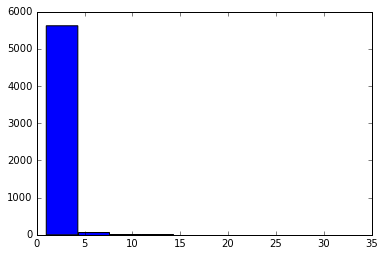

In [147]:
plt.hist(s1df.n_s12, bins=10)

(array([  5.43600000e+03,   0.00000000e+00,   1.04400000e+03,
          0.00000000e+00,   0.00000000e+00,   1.24000000e+02,
          0.00000000e+00,   7.00000000e+00,   0.00000000e+00,
          1.00000000e+00]),
 array([ 1. ,  1.4,  1.8,  2.2,  2.6,  3. ,  3.4,  3.8,  4.2,  4.6,  5. ]),
 <a list of 10 Patch objects>)

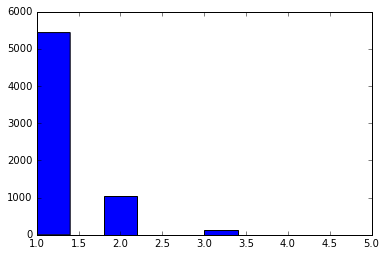

In [148]:
plt.hist(s2df.n_s12, bins=10)

(array([ 1342.,  1127.,  1249.,   777.,   398.,   220.,   158.,   103.,
           79.,    74.,    46.,    52.,    35.,    24.,    22.,    20.,
            8.,     5.,     4.,     3.]),
 array([   4.45227124,   24.32914339,   44.20601554,   64.08288769,
          83.95975984,  103.83663199,  123.71350414,  143.59037629,
         163.46724844,  183.34412059,  203.22099274,  223.09786489,
         242.97473704,  262.85160919,  282.72848134,  302.60535349,
         322.48222564,  342.35909778,  362.23596993,  382.11284208,
         401.98971423]),
 <a list of 20 Patch objects>)

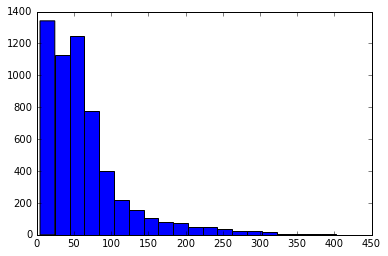

In [149]:
plt.hist(s1df.pes, bins=20)

(array([  3.54400000e+03,   2.05800000e+03,   4.89000000e+02,
          2.04000000e+02,   1.00000000e+02,   7.80000000e+01,
          4.90000000e+01,   3.40000000e+01,   1.40000000e+01,
          1.30000000e+01,   9.00000000e+00,   2.00000000e+00,
          9.00000000e+00,   3.00000000e+00,   0.00000000e+00,
          3.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   1.00000000e+00]),
 array([  2.86974974e+02,   1.63526443e+04,   3.24183137e+04,
          4.84839830e+04,   6.45496523e+04,   8.06153217e+04,
          9.66809910e+04,   1.12746660e+05,   1.28812330e+05,
          1.44877999e+05,   1.60943668e+05,   1.77009338e+05,
          1.93075007e+05,   2.09140676e+05,   2.25206346e+05,
          2.41272015e+05,   2.57337684e+05,   2.73403354e+05,
          2.89469023e+05,   3.05534692e+05,   3.21600362e+05]),
 <a list of 20 Patch objects>)

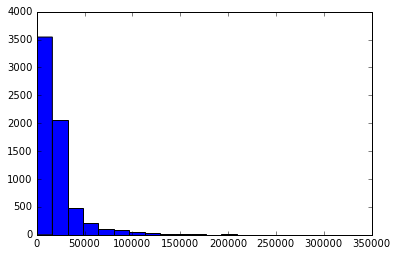

In [150]:
plt.hist(s2df.pes, bins=20)

(array([ 1350.,   831.,   788.,   723.,   586.,   501.,   335.,   231.,
          178.,   223.]),
 array([  8. ,   9.1,  10.2,  11.3,  12.4,  13.5,  14.6,  15.7,  16.8,
         17.9,  19. ]),
 <a list of 10 Patch objects>)

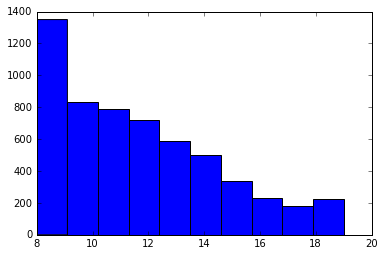

In [152]:
plt.hist(s1df.width.values, bins=10)

(array([  6.19000000e+03,   3.28000000e+02,   6.20000000e+01,
          2.50000000e+01,   3.00000000e+00,   1.00000000e+00,
          2.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00]),
 array([  100. ,  1030.5,  1961. ,  2891.5,  3822. ,  4752.5,  5683. ,
         6613.5,  7544. ,  8474.5,  9405. ]),
 <a list of 10 Patch objects>)

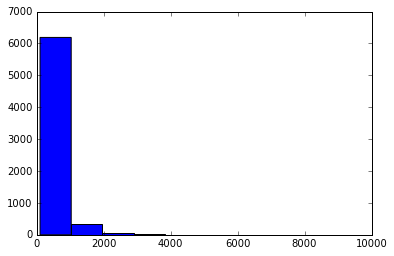

In [153]:
plt.hist(s2df.width.values)

(array([   36.,   114.,   150.,   203.,   368.,  1025.,  1969.,  1338.,
          477.,    66.]),
 array([ 0.06742749,  0.08439654,  0.10136558,  0.11833463,  0.13530367,
         0.15227272,  0.16924177,  0.18621081,  0.20317986,  0.2201489 ,
         0.23711795]),
 <a list of 10 Patch objects>)

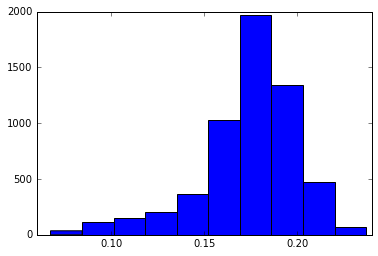

In [154]:
plt.hist(s1df.peak_to_pes)

(array([  2.57300000e+03,   2.98800000e+03,   7.17000000e+02,
          2.61000000e+02,   5.40000000e+01,   9.00000000e+00,
          5.00000000e+00,   3.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.00000000e+00]),
 array([ 0.00012665,  0.00449345,  0.00886025,  0.01322705,  0.01759385,
         0.02196065,  0.02632745,  0.03069425,  0.03506105,  0.03942785,
         0.04379465,  0.04816145,  0.05252825,  0.05689505,  0.06126185,
         0.06562865,  0.06999545,  0.07436225,  0.07872905,  0.08309585,
         0.08746266]),
 <a list of 20 Patch objects>)

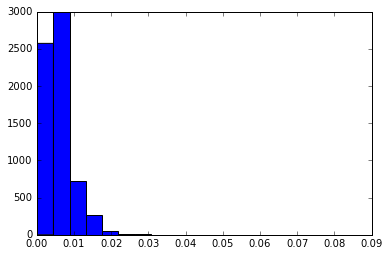

In [155]:
plt.hist(s2df.peak_to_pes, bins=20)

(array([  83.,  260.,  265.,  244.,  273.,  229.,  211.,  224.,  234.,
         260.,  211.,  274.,  252.,  241.,  268.,  282.,  268.,  343.,
         433.,  891.]),
 array([   1.15  ,   30.5925,   60.035 ,   89.4775,  118.92  ,  148.3625,
         177.805 ,  207.2475,  236.69  ,  266.1325,  295.575 ,  325.0175,
         354.46  ,  383.9025,  413.345 ,  442.7875,  472.23  ,  501.6725,
         531.115 ,  560.5575,  590.    ]),
 <a list of 20 Patch objects>)

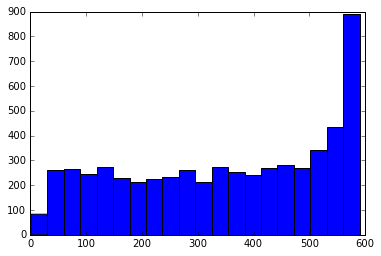

In [156]:
plt.hist(s1df.tpeak/units.mus, bins=20)

(array([ 2045.,  3255.,   524.,   252.,   113.,    96.,    47.,    49.,
           28.,    23.,    22.,    17.,    25.,    17.,    13.,    14.,
           12.,    12.,     9.,    39.]),
 array([ 592.75  ,  608.1125,  623.475 ,  638.8375,  654.2   ,  669.5625,
         684.925 ,  700.2875,  715.65  ,  731.0125,  746.375 ,  761.7375,
         777.1   ,  792.4625,  807.825 ,  823.1875,  838.55  ,  853.9125,
         869.275 ,  884.6375,  900.    ]),
 <a list of 20 Patch objects>)

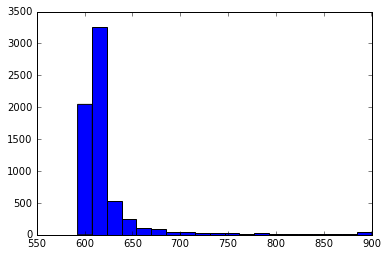

In [157]:
plt.hist(s2df.tpeak/units.mus, bins=20)

In [215]:
s12df.head()

,n_s1,n_s2,peak_s1,peak_s2,peak_to_pes_s1,peak_to_pes_s2,pes_s1,pes_s2,tpeak_s1,tpeak_s2,width_s1,width_s2
0,1,1,[29.3389360949],[145.205308681],[0.17324373899],[0.00278374442982],[169.350628576],[52161.8677079],[274750.0],[629150.0],[17],[1253]
1,1,1,[7.94937436823],[113.554181594],[0.16681652103],[0.00532557003387],[47.6533997899],[21322.4463995],[405550.0],[608675.0],[13],[450]
2,1,1,[6.4813964103],[56.5409694054],[0.180994970155],[0.00390555185074],[35.8098150724],[14477.0756006],[284125.0],[616450.0],[11],[765]
3,1,2,[6.98972217801],"[45.4465677511, 23.1268156712]",[0.176420546475],"[0.00487081603211, 0.00635718648924]",[39.6196606214],"[9330.38066958, 3637.901092]",[281075.0],"[607375.0, 621450.0]",[17],"[460, 380]"
4,1,1,[2.59174633397],[124.879611212],[0.181404918904],[0.0111643751308],[14.2870785954],[11185.5441751],[579900.0],[604175.0],[8],[205]


In [219]:
def select_ns12(s12df, n_s1=1, n_s2=1):
    s12df_ = s12df[(s12df.n_s1 == n_s1)]
    return s12df_[(s12df_.n_s2 == n_s2)]

In [240]:
def select_pes_s2(df, s2_pes_min=0, s2_pes_max=7000):
    df_ = df[df.pes_s2 > s2_pes_min]
    return df_[df_.pes_s2 < s2_pes_max]

In [220]:
def select_columns(df,column_list):
    return df.loc[:,column_list]

In [224]:
pes_s1s2_1  = select_columns(select_ns12(s12df, n_s1=1, n_s2=1),['pes_s1','pes_s2'])

In [226]:
pes_s1s2_1.head()

,pes_s1,pes_s2
0,[169.350628576],[52161.8677079]
1,[47.6533997899],[21322.4463995]
2,[35.8098150724],[14477.0756006]
4,[14.2870785954],[11185.5441751]
6,[148.763296891],[26899.3040679]


In [229]:
def get_array_from_dfc(dfc,indx=0):
    dfl = []
    for i in range(len(dfc.values)):
        dfl.append(dfc.values[i][indx])
    return np.array(dfl)



In [230]:
get_array_from_dfc(pes_s1s2_1.pes_s1,indx=0)

array([ 169.35062858,   47.65339979,   35.80981507, ...,   26.94600458,
         91.42801187,   75.71940298])

In [241]:
def data_frame_from_array(name_list, array_list):
    swf = {}
    assert(len(name_list) == len(array_list))
    
    for i, name in enumerate(name_list):
        swf[name] = array_list[i]
    return pd.DataFrame(swf)

In [242]:
pesDF = data_frame_from_array(['pes_s1','pes_s2'],
                              [get_array_from_dfc(pes_s1s2_1.pes_s1),get_array_from_dfc(pes_s1s2_1.pes_s2)])

In [243]:
pesDF.head()

,pes_s1,pes_s2
0,169.350629,52161.867708
1,47.653400,21322.446399
2,35.809815,14477.075601
3,14.287079,11185.544175
4,148.763297,26899.304068


In [244]:
krDF = select_pes_s2(pesDF, s2_pes_min=5000, s2_pes_max=7000)

In [246]:
krDF.head()

,pes_s1,pes_s2
7,10.344556,5683.908684
77,20.202620,5149.962887
94,9.641185,5900.621515
97,15.893162,6200.714249
117,13.016670,5206.257505


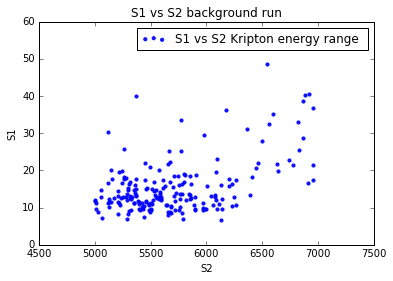

In [250]:
plt.scatter(krDF.pes_s2[krDF.pes_s1<50],krDF.pes_s1[krDF.pes_s1<50],
           # the marker as
            marker='o',
            # the color
            color='b',
            # the alpha
            alpha=0.9,
            # with size
            s = 10,
            # labelled this
            label='S1 vs S2 Kripton energy range ')
# Chart title
plt.title('S1 vs S2 background run')

# y label
plt.ylabel('S1')

# x label
plt.xlabel('S2')

# and a legend
plt.legend(loc='upper right')

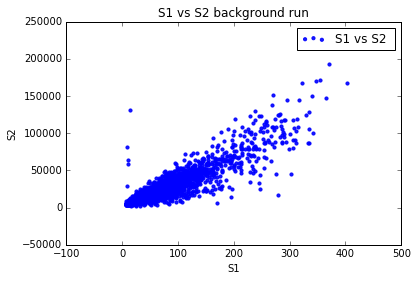

In [239]:
plt.scatter(get_array_from_dfc(pes_s1s2_1.pes_s1), get_array_from_dfc(pes_s1s2_1.pes_s2),
           # the marker as
            marker='o',
            # the color
            color='b',
            # the alpha
            alpha=0.9,
            # with size
            s = 10,
            # labelled this
            label='S1 vs S2 ')
# Chart title
plt.title('S1 vs S2 background run')

# y label
plt.ylabel('S2')

# x label
plt.xlabel('S1')

# and a legend
plt.legend(loc='upper right')